## Benchmark Simulations
2024-08-22

Benchmark simulations for all portfolios

In [338]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn
import investpy
import pandas_market_calendars as mcal
from tqdm.notebook import tqdm

In [ ]:
def convert_dates(datelist):
    for i in range(len(datelist)):
        datelist[i] = datelist[i].strftime('%Y-%m-%d')
    return [x.strftime('%Y-%m-%d') for x in datelist]
    
# trading calendar
nyse = mcal.get_calendar('NYSE')
lse = mcal.get_calendar('LSE')

# quarterly datelist
quarterly_dates_spx = convert_dates(nyse.valid_days(start_date='2010-04-01', end_date='2024-04-01').to_series().resample('QE').last())
quarterly_dates_euro = convert_dates(lse.valid_days(start_date='2010-04-01', end_date='2024-04-01').to_series().resample('QE').last())
        
# monthly datelist
monthly_dates_spx = convert_dates(nyse.valid_days(start_date='2010-04-01', end_date='2024-04-01').to_series().resample('ME').last())
monthly_dates_euro = convert_dates(lse.valid_days(start_date='2010-04-01', end_date='2024-04-01').to_series().resample('ME').last())

# list of Wednesdays
weekly_dates_spx = convert_dates(nyse.valid_days(start_date='2010-04-01', end_date='2024-04-01').to_series().resample('W-WED').last())
weekly_dates_euro = convert_dates(lse.valid_days(start_date='2010-04-01', end_date='2024-04-01').to_series().resample('W-WED').last())

In [340]:
# store portfolio returns
returns = {'Weekly': {}, 'Monthly': {}, 'Quarterly': {}}

In [415]:
# date - for given date
# const - constituents dictionary
# financial_utils - True if financial and utilities grouping false if other
# above - true if above median market cap otherwise false
# sector - sector mapping data
def generate_isin(date, const):
    return const.get(date, [])


# sell portfolio holdigns at prices
# x - the type of portfolio
def liquidate(portfolios, price, x, d):
    if len(portfolios[x]['holdings']):
        prices = pd.Series([price[isin][price[isin]['date'] <= d].iloc[-1]['close'] for isin in portfolios[x]['holdings'].index])
        prices.index = portfolios[x]['holdings'].index
        portfolios[x]['account_value'] = sum(prices * portfolios[x]['holdings'])
    portfolios[x]['history'].append(portfolios[x]['account_value']) 
    return portfolios

# determine percentage of portfolio allocated to each holding (equal weighted right now)
def allocate_equal(portfolios, x, price, d, df):
    portfolios[x]['holdings'] = portfolios[x]['account_value']/len(df.loc[d])/df.loc[d]['price']
    return portfolios
    
# determine percentage of portfolio allocated based on market cap
def allocate_mc(d, portfolios, x, df):
    tmc = sum(df.loc[d]['mc'] * df.loc[d]['freefloat'])
    portfolios[x]['holdings'] = portfolios[x]['account_value'] * (df.loc[d]['mc'] * df.loc[d]['freefloat'] / df.loc[d]['price'])/tmc    
    return portfolios

def rd(x):
    return round(x, 3) 
    
# Calculate Portfolio Returns
def portfolioMetrics(history, frame):
    if frame == 'Yearly':
        DIV = 1
    elif frame == 'Quarterly':
        DIV = 4
    elif frame == 'Monthly':
        DIV = 12
    elif frame == 'Weekly':
        DIV = 52
    annual_return = (history[-1]/history[0])**(1/(len(history)/DIV)) - 1
    annual_std = np.array([(history[i] - history[i - 1])/history[i - 1] for i in range(1, len(history))]).std() * np.sqrt(DIV)
    print(f"Average Return (Per Annum): {rd(((history[-1]/history[0])**(1/len(history)))**DIV)}")
    print(f"Final Value: {rd(history[-1])}\n")

In [418]:
def simulate(datelist, price, df, name, frame, allocate='equal'):
    portfolios = {'benchmark': {'account_value': 100000, 'holdings': {}, 'history': []}}
    for i in tqdm(range(len(datelist))):
        # parse current date
        date = datelist[i]
        portfolios = liquidate(portfolios, price, 'benchmark', date)
        if allocate == 'marketcap':
            portfolios = allocate_mc(date, portfolios, 'benchmark', df)
        else:
            portfolios = allocate_equal(portfolios, 'benchmark', price, date, df)
    portfolios = liquidate(portfolios, price, 'benchmark', date)
    portfolios['benchmark']['history'] = portfolios['benchmark']['history'][1:]
    title = f'{name}/benchmark/ALL/{frame}/{allocate}'
    returns[frame][title] = portfolios["benchmark"]['history']
    print(f"{name}/benchmark/ALL/{frame}/{allocate}")
    # Display Metrics
    print("\n\033[4mBenchmark Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['benchmark']['history'], frame)
    fig = make_subplots()
    fig.add_trace(go.Scatter(x=datelist, y=portfolios['benchmark']['history'], mode='lines', name='benchmark'))
    fig.update_layout(
        title=f'Portfolio Performance Benchmark',
        xaxis_title='Date',
        yaxis_title='Portfolio Value',
        legend_title='Portfolios',
        template='plotly_dark', # Set dark theme
        xaxis=dict(tickangle=-45) 
    )
    fig.show()

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [01:48<00:00,  1.55it/s]


SPX/benchmark/ALL/Monthly/marketcap

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.121
Final Value: 456986.846



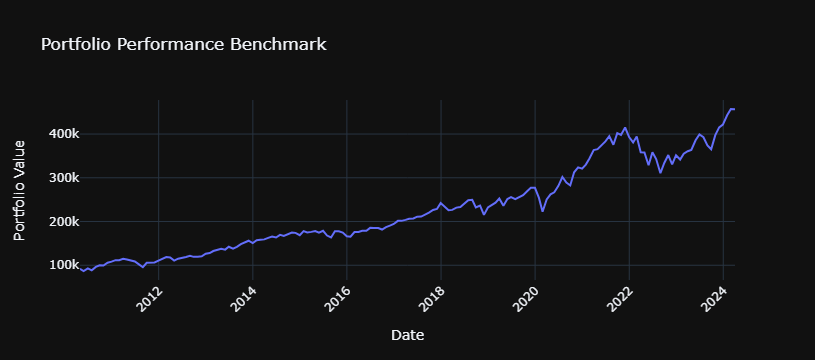

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [01:35<00:00,  1.77it/s]


SPX/benchmark/ALL/Monthly/equal

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.108
Final Value: 392466.062



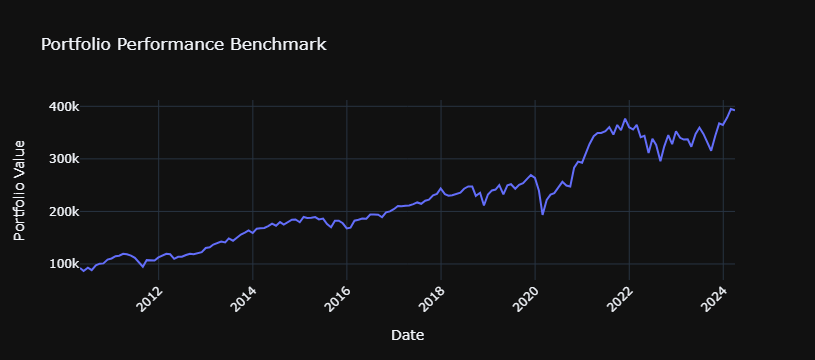

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:28<00:00,  1.97it/s]


SPX/benchmark/ALL/Quarterly/marketcap

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.115
Final Value: 524182.176



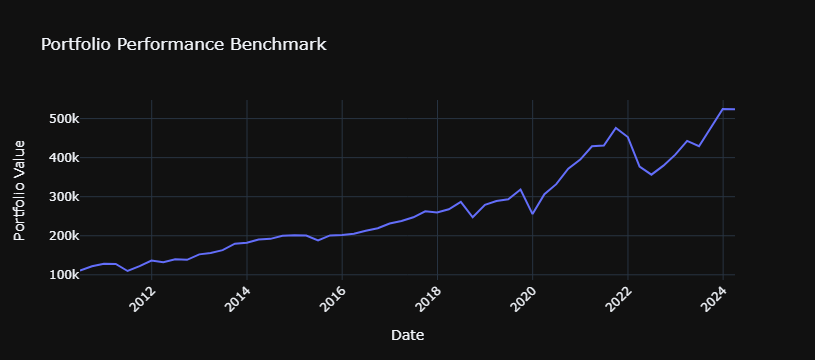

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:22<00:00,  2.55it/s]


SPX/benchmark/ALL/Quarterly/equal

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.103
Final Value: 454894.244



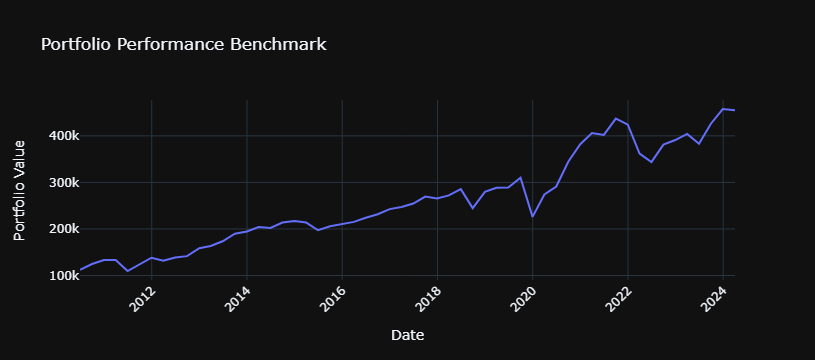

100%|████████████████████████████████████████████████████████████████████████████████| 731/731 [05:47<00:00,  2.10it/s]


SPX/benchmark/ALL/Weekly/marketcap

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.112
Final Value: 458564.616



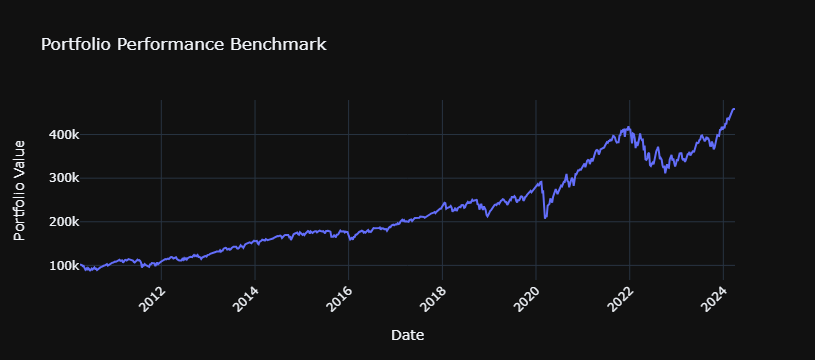

100%|████████████████████████████████████████████████████████████████████████████████| 731/731 [05:42<00:00,  2.13it/s]


SPX/benchmark/ALL/Weekly/equal

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.104
Final Value: 411621.318



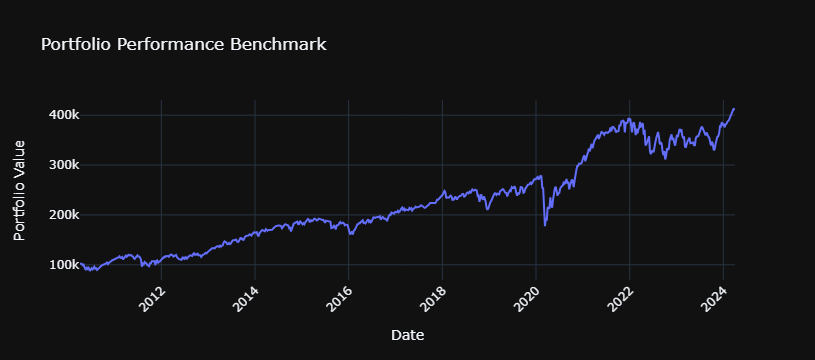

In [419]:
# S&P Benchmarks
for dates, name in [(monthly_dates_spx, 'Monthly'), (quarterly_dates_spx, 'Quarterly'), (weekly_dates_spx, 'Weekly')]:
    for alloc in ['marketcap', 'equal']:
        simulate(dates, spx_price, spx_df, 'SPX', name, allocate=alloc)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:26<00:00,  2.15it/s]


EURO/benchmark/ALL/Quarterly/marketcap

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.044
Final Value: 197222.99



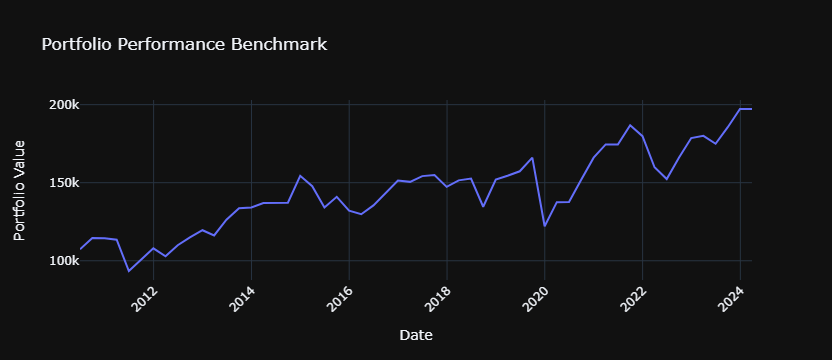

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:28<00:00,  1.99it/s]


EURO/benchmark/ALL/Quarterly/equal

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.05
Final Value: 215203.545



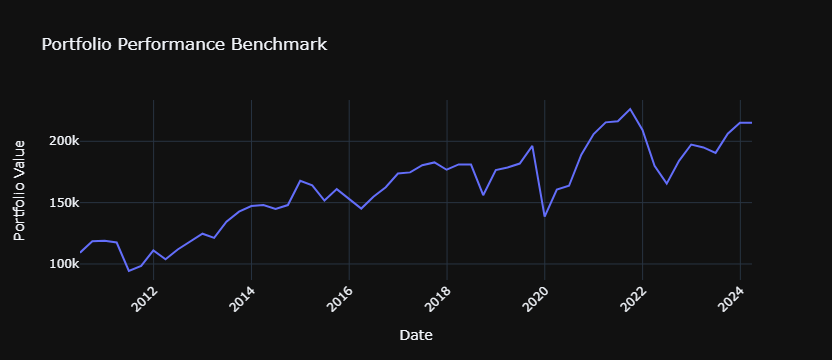

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:21<00:00,  2.05it/s]


EURO/benchmark/ALL/Monthly/marketcap

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.051
Final Value: 188152.933



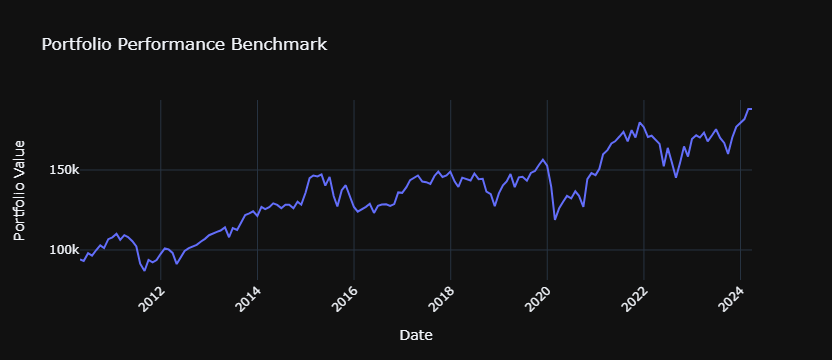

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:28<00:00,  1.89it/s]


EURO/benchmark/ALL/Monthly/equal

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.057
Final Value: 202744.216



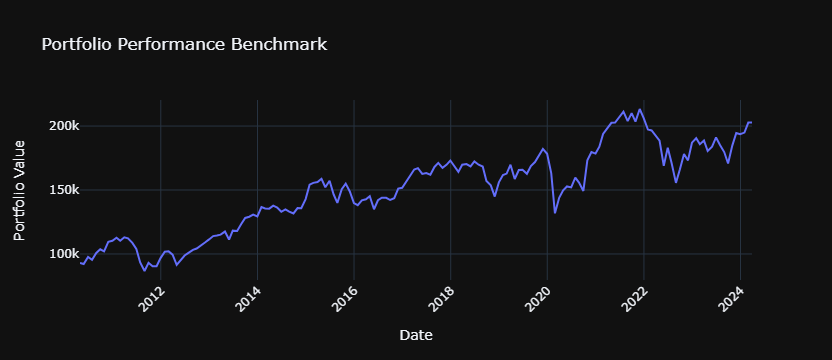

100%|████████████████████████████████████████████████████████████████████████████████| 731/731 [05:37<00:00,  2.17it/s]


EURO/benchmark/ALL/Weekly/marketcap

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.043
Final Value: 182678.457



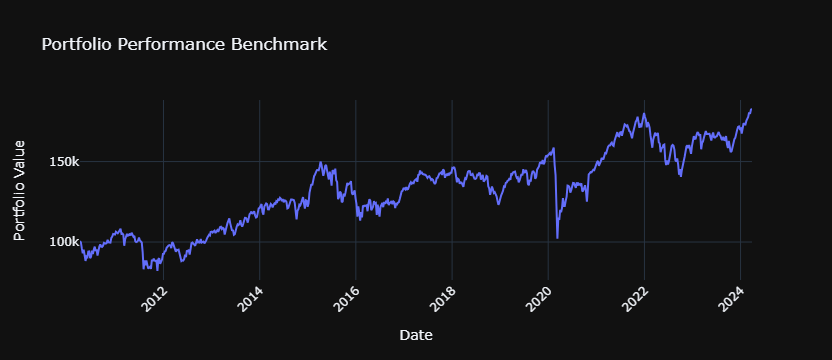

100%|████████████████████████████████████████████████████████████████████████████████| 731/731 [06:09<00:00,  1.98it/s]


EURO/benchmark/ALL/Weekly/equal

Benchmark Portfolio Metrics
Average Return (Per Annum): 1.053
Final Value: 208670.304



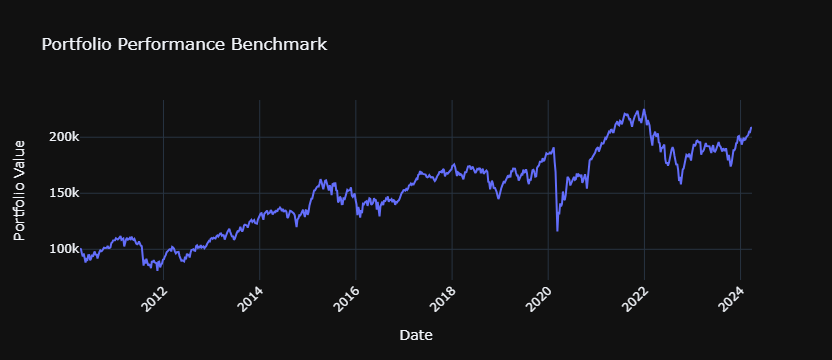

In [420]:
# Euro Benchmarks
for dates, name in [(quarterly_dates_euro, 'Quarterly'), (monthly_dates_euro, 'Monthly'), (weekly_dates_euro, 'Weekly')]:
    for alloc in ['marketcap', 'equal']:
        simulate(dates, euro_price, euro_df, 'EURO', name, allocate=alloc)